In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib.pyplot import figure

### 

In [2]:
combats_raw = pd.read_csv('combats.csv')
print(combats_raw.shape)
combats_raw.head()

(50000, 3)


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [3]:
all_pokemon = pd.read_csv('merged_pokemon.csv')
all_pokemon.head()

,Unnamed: 0,#,Name,Type 1,Type 2,Abilities,HP,Att,Def,Spa,...,Against Bug,Against Rock,Against Ghost,Against Dragon,Against Dark,Against Steel,Against Fairy,Height,Weight,BMI
0,0,1,Bulbasaur,Grass,Poison,"['Chlorophyll', 'Overgrow']",45,49,49,65,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.7,6.9,14.1
1,1,2,Ivysaur,Grass,Poison,"['Chlorophyll', 'Overgrow']",60,62,63,80,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,13.0,13.0
2,2,3,Venusaur,Grass,Poison,"['Chlorophyll', 'Overgrow']",80,82,83,100,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,2.0,100.0,25.0
3,3,4,Mega Venusaur,Grass,Poison,['Thick Fat'],80,100,123,122,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,2.4,155.5,27.0
4,4,5,Charmander,Fire,NaN,"['Blaze', 'Solar Power']",39,52,43,60,...,0.5,2.0,1.0,1.0,1.0,0.5,0.5,0.6,8.5,23.6


In [4]:
first_pokemon = combats_raw.merge(all_pokemon[['#', 'Name']], left_on = 'First_pokemon', right_on = '#', sort = False, how = 'left')['Name']
second_pokemon = combats_raw.merge(all_pokemon[['#', 'Name']], left_on = 'Second_pokemon', right_on = '#', sort = False, how = 'left')['Name']
winner = combats_raw.merge(all_pokemon[['#', 'Name']], left_on = 'Winner', right_on = '#', sort = False, how = 'left')['Name']

combats_raw['Pokemon'] = first_pokemon
combats_raw['Opponent'] = second_pokemon
combats_raw['Winner'] = winner
combats = combats_raw[['Pokemon', 'Opponent', 'Winner']]

combats.head()

,Pokemon,Opponent,Winner
0,Larvitar,Nuzleaf,Nuzleaf
1,Virizion,Terrakion,Terrakion
2,Togetic,Beheeyem,Beheeyem
3,Slugma,Druddigon,Druddigon
4,Omastar,Shuckle,Omastar


In [5]:
features = ['Name', 'Type 1', 'Type 2', 'HP', 'Att', 'Def', 'Spa', 'Spd', 'Spe'] + list(all_pokemon.columns)[24:-3]
features

['Name',
 'Type 1',
 'Type 2',
 'HP',
 'Att',
 'Def',
 'Spa',
 'Spd',
 'Spe',
 'Against Normal',
 'Against Fire',
 'Against Water',
 'Against Electric',
 'Against Grass',
 'Against Ice',
 'Against Fighting',
 'Against Poison',
 'Against Ground',
 'Against Flying',
 'Against Psychic',
 'Against Bug',
 'Against Rock',
 'Against Ghost',
 'Against Dragon',
 'Against Dark',
 'Against Steel',
 'Against Fairy']

In [6]:
pokemon_features = combats.merge(all_pokemon[features], left_on = 'Pokemon', right_on = 'Name', how = 'left')

pokemon_renames = {}
opponent_renames = {}
for col in features:
    pokemon_renames[col] = 'Pokemon '  + col
    opponent_renames[col] = 'Opponent ' + col

pokemon_renamed_features = pokemon_features.rename(columns = pokemon_renames).drop('Pokemon Name', axis = 1)
opponent_features = pokemon_renamed_features.merge(all_pokemon[features], left_on = 'Opponent', right_on = 'Name', how = 'left')
raw_features = opponent_features.rename(columns = opponent_renames).drop('Opponent Name', axis=1)
raw_features.head()

,Pokemon,Opponent,Winner,Pokemon Type 1,Pokemon Type 2,Pokemon HP,Pokemon Att,Pokemon Def,Pokemon Spa,Pokemon Spd,...,Opponent Against Ground,Opponent Against Flying,Opponent Against Psychic,Opponent Against Bug,Opponent Against Rock,Opponent Against Ghost,Opponent Against Dragon,Opponent Against Dark,Opponent Against Steel,Opponent Against Fairy
0,Larvitar,Nuzleaf,Nuzleaf,Rock,Ground,50,64,50,45,50,...,0.5,2.0,0.0,4.0,1.0,0.5,1.0,0.5,1.0,2.0
1,Virizion,Terrakion,Terrakion,Grass,Fighting,91,90,72,90,129,...,2.0,1.0,2.0,0.5,0.5,1.0,1.0,0.5,2.0,2.0
2,Togetic,Beheeyem,Beheeyem,Fairy,Flying,55,40,85,80,105,...,1.0,1.0,0.5,2.0,1.0,2.0,1.0,2.0,1.0,1.0
3,Slugma,Druddigon,Druddigon,Fire,NaN,40,40,40,70,40,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0
4,Omastar,Shuckle,Omastar,Rock,Water,70,60,125,115,70,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0


In [7]:
for i in features[3:9]:
    raw_features[i + ' diff'] = raw_features['Pokemon ' + i] - raw_features['Opponent ' + i]

In [8]:
ovps = []
pvos = []
for i in range(raw_features.shape[0]):
    p_type1 = raw_features['Pokemon Type 1'].iloc[i]
    p_type2 = raw_features['Pokemon Type 2'].iloc[i]
    o_type1 = raw_features['Opponent Type 1'].iloc[i]
    o_type2 = raw_features['Opponent Type 2'].iloc[i]

    p_first_against = "Pokemon Against " + o_type1
    o_vs_p = raw_features[p_first_against].iloc[i]
    if not pd.isna(o_type2):
        p_second_against = "Pokemon Against " + o_type2
        o_vs_p = max(o_vs_p, raw_features[p_second_against].iloc[i])

    o_first_against = "Opponent Against " + p_type1
    p_vs_o = raw_features[o_first_against].iloc[i]
    if not pd.isna(p_type2):
        o_second_against = "Opponent Against " + p_type2
        p_vs_o = max(p_vs_o, raw_features[o_second_against].iloc[i])

    ovps.append(o_vs_p)
    pvos.append(p_vs_o)

In [9]:
raw_features['Opponent vs. Pokemon'] = ovps
raw_features['Pokemon vs. Opponent'] = pvos
raw_features['Win'] = (raw_features['Pokemon'] == raw_features['Winner']).astype(int)
raw_features.head()

,Pokemon,Opponent,Winner,Pokemon Type 1,Pokemon Type 2,Pokemon HP,Pokemon Att,Pokemon Def,Pokemon Spa,Pokemon Spd,...,Opponent Against Fairy,HP diff,Att diff,Def diff,Spa diff,Spd diff,Spe diff,Opponent vs. Pokemon,Pokemon vs. Opponent,Win
0,Larvitar,Nuzleaf,Nuzleaf,Rock,Ground,50,64,50,45,50,...,2.0,-20,-6,10,-15,10,-19,4.0,1.0,0
1,Virizion,Terrakion,Terrakion,Grass,Fighting,91,90,72,90,129,...,2.0,0,-39,-18,18,39,0,1.0,2.0,0
2,Togetic,Beheeyem,Beheeyem,Fairy,Flying,55,40,85,80,105,...,1.0,-20,-35,10,-45,10,0,1.0,1.0,0
3,Slugma,Druddigon,Druddigon,Fire,NaN,40,40,40,70,40,...,2.0,-37,-80,-50,10,-50,-28,1.0,0.5,0
4,Omastar,Shuckle,Omastar,Rock,Water,70,60,125,115,70,...,1.0,50,50,-105,105,-160,50,1.0,2.0,1


In [10]:
raw_features.to_csv('pokemon_fight_data.csv', index = False)

In [ ]:
final_features = raw_features[['Pokemon', 'Opponent', 'HP diff', 'Att diff', 'Def diff', 'Spa diff', 'Spd diff', 'Spe diff', 'Opponent vs. Pokemon', 'Pokemon vs. Opponent', 'Win']].drop_duplicates()
final_features.head()

,Pokemon,Opponent,HP diff,Att diff,Def diff,Spa diff,Spd diff,Spe diff,Opponent vs. Pokemon,Pokemon vs. Opponent,Win
0,Larvitar,Nuzleaf,-20,-6,10,-15,10,-19,4.0,1.0,0
1,Virizion,Terrakion,0,-39,-18,18,39,0,1.0,2.0,0
2,Togetic,Beheeyem,-20,-35,10,-45,10,0,1.0,1.0,0
3,Slugma,Druddigon,-37,-80,-50,10,-50,-28,1.0,0.5,0
4,Omastar,Shuckle,50,50,-105,105,-160,50,1.0,2.0,1


In [ ]:
X = final_features[['HP diff', 'Att diff', 'Def diff', 'Spa diff', 'Spd diff', 'Spe diff', 'Opponent vs. Pokemon', 'Pokemon vs. Opponent']]
y = final_features[['Win']]
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(15), solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp.fit(x_train, y_train)
y_train_predictions = mlp.predict(x_train)
accuracy_score(y_train, y_train_predictions)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.9405824636285558

In [ ]:
y_val_predictions = mlp.predict(x_val)
accuracy_score(y_val, y_val_predictions)

0.9413907974182802

In [ ]:
lr = sklearn.linear_model.LogisticRegression(fit_intercept=True, solver = 'lbfgs', random_state = 42)
lr.fit(x_train, y_train)
accuracy_score(y_train, lr.predict(x_train))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8850428128985243

In [ ]:
accuracy_score(y_val, lr.predict(x_val))

0.8906933166770769

In [ ]:
combats_tests = pd.read_csv('combats_tests.csv')
combats_tests.head()

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


In [ ]:
#Given a Pokemon and an Opponent as two columns of a table,
#create the table of features X to input into the model

def pokebattle_features(tbl):
    first_pokemon = tbl.merge(all_pokemon[['#', 'Name']], left_on = 'First_pokemon', right_on = '#', sort = False, how = 'left')['Name']
    second_pokemon = tbl.merge(all_pokemon[['#', 'Name']], left_on = 'Second_pokemon', right_on = '#', sort = False, how = 'left')['Name']
    tbl['Pokemon'] = first_pokemon
    tbl['Opponent'] = second_pokemon
    combats = tbl[['Pokemon', 'Opponent']]
    all_features = combats.merge(all_pokemon[features], left_on = 'Pokemon', right_on = 'Name', how = 'left')
    poke_renames = {}
    opp_renames = {}
    for col in features:
        poke_renames[col] = 'Pokemon '  + col
        opp_renames[col] = 'Opponent ' + col
    poke_renamed_features = all_features.rename(columns = poke_renames).drop('Pokemon Name', axis = 1)
    opp_features = poke_renamed_features.merge(all_pokemon[features], left_on = 'Opponent', right_on = 'Name', how = 'left')
    raw_features = opp_features.rename(columns = opp_renames).drop('Opponent Name', axis=1)
    for i in features[3:9]:
        raw_features[i + ' diff'] = raw_features['Pokemon ' + i] - raw_features['Opponent ' + i]
    ovps = []
    pvos = []
    for i in range(raw_features.shape[0]):
        p_type1 = raw_features['Pokemon Type 1'].iloc[i]
        p_type2 = raw_features['Pokemon Type 2'].iloc[i]
        o_type1 = raw_features['Opponent Type 1'].iloc[i]
        o_type2 = raw_features['Opponent Type 2'].iloc[i]
        p_first_against = "Pokemon Against " + o_type1
        o_vs_p = raw_features[p_first_against].iloc[i]
        if not pd.isna(o_type2):
            p_second_against = "Pokemon Against " + o_type2
            o_vs_p = max(o_vs_p, raw_features[p_second_against].iloc[i])
        o_first_against = "Opponent Against " + p_type1
        p_vs_o = raw_features[o_first_against].iloc[i]
        if not pd.isna(p_type2):
            o_second_against = "Opponent Against " + p_type2
            p_vs_o = max(p_vs_o, raw_features[o_second_against].iloc[i])
        ovps.append(o_vs_p)
        pvos.append(p_vs_o)
    raw_features['Opponent vs. Pokemon'] = ovps
    raw_features['Pokemon vs. Opponent'] = pvos
    raw_features = raw_features.drop_duplicates()
    pokemon_name_table = raw_features[['Pokemon', 'Opponent']]
    final_features = raw_features[['HP diff', 'Att diff', 'Def diff', 'Spa diff', 'Spd diff', 'Spe diff', 'Opponent vs. Pokemon', 'Pokemon vs. Opponent']]
    return pokemon_name_table, final_features


tests = pokebattle_features(combats_tests)
test_features = tests[1]
test_features.head()

,HP diff,Att diff,Def diff,Spa diff,Spd diff,Spe diff,Opponent vs. Pokemon,Pokemon vs. Opponent
0,-10,37,-10,5,5,38,1.0,1.0
1,-21,9,46,-11,51,-15,1.0,4.0
2,29,-15,17,110,-30,14,0.5,2.0
3,-5,-31,-12,-26,-7,-15,1.0,0.5
4,-125,-15,-50,-9,-14,5,1.0,1.0


In [ ]:
test_y = mlp.predict(test_features)

In [ ]:
pokemon_wins = tests[0]
pokemon_wins['Win'] = test_y
pokemon_wins

,Pokemon,Opponent,Win
0,Seaking,Lickitung,1
1,Ferrothorn,Quagsire,0
2,Thundurus-Therian,Hitmonlee,1
3,Flaaffy,Maractus,0
4,Spearow,Alomomola,1
...,...,...,...
10095,Misdreavus,Lucario,0
10096,Cubone,Gorebyss,0
10097,Gabite,Onix,1
10098,Swanna,Elekid,1


In [ ]:
final_features['Pokemon'].value_counts()

Meowstic       111
Keldeo          91
Mewtwo          87
Illumise        87
Alakazam        85
              ... 
Mantyke         42
Lillipup        42
Sneasel         42
Karrablast      39
Mega Glalie     38
Name: Pokemon, Length: 782, dtype: int64

In [ ]:
final_features['Opponent'].value_counts()

Keldeo        127
Meowstic      117
Malamar        85
Pidove         84
Leafeon        82
             ... 
Basculin       44
Chandelure     43
Landorus       42
Metagross      38
Magmortar      38
Name: Opponent, Length: 782, dtype: int64

In [ ]:
test_pokemon_names = pd.DataFrame(pokemon_wins['Pokemon'].value_counts().sort_index() + pokemon_wins['Opponent'].value_counts().sort_index())
test_pokemon_names = test_pokemon_names.reset_index().rename(columns = {'index' : 'Pokemon', 0 : 'Fights'}).sort_values('Pokemon')
test_pokemon_names.head()

,Pokemon,Fights
0,Abomasnow,22
1,Abra,25
2,Absol,24
3,Accelgor,24
4,Aegislash Blade Form,25


In [ ]:
pokemon_wins2 = pokemon_wins[['Opponent', 'Win']]
pokemon_wins2['Win'].replace({1:0, 0:1}, inplace=True)
pokemon_wins2.head()

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Opponent,Win
0,Lickitung,0
1,Quagsire,1
2,Hitmonlee,0
3,Maractus,1
4,Alomomola,0


In [ ]:
pokemon_wins2 = pokemon_wins2.groupby('Opponent').sum().reset_index().rename(columns = {'index' : 'Pokemon', 0 : 'Wins'}).sort_values('Opponent')
pokemon_wins1 = pokemon_wins[['Pokemon', 'Win']].groupby('Pokemon').sum().reset_index().rename(columns = {'index' : 'Pokemon', 0 : 'Wins'}).sort_values('Pokemon')
total_pokemon_wins = pokemon_wins1.merge(pokemon_wins2, left_on='Pokemon', right_on='Opponent')
total_pokemon_wins['Wins'] = total_pokemon_wins['Win_x'] + total_pokemon_wins['Win_y']
total_pokemon_wins = total_pokemon_wins[['Pokemon', 'Wins']]
total_pokemon_wins['Fights'] = test_pokemon_names['Fights']
total_pokemon_wins['% Wins'] = total_pokemon_wins['Wins'] / total_pokemon_wins['Fights']
total_pokemon_wins = total_pokemon_wins.sort_values('% Wins', ascending=False)
total_pokemon_wins

,Pokemon,Wins,Fights,% Wins
434,Mega Mewtwo Y,18,18,1.0
416,Mega Gallade,17,17,1.0
352,Liepard,18,18,1.0
687,Swellow,26,26,1.0
549,Pyroar,21,21,1.0
...,...,...,...,...
617,Shelmet,0,26,0.0
305,Jigglypuff,0,18,0.0
382,Makuhita,0,26,0.0
443,Mega Slowbro,0,19,0.0


In [ ]:
base_stats = all_pokemon[['Name', 'Type 1', 'Type 2', 'HP', 'Att', 'Def', 'Spa', 'Spd', 'Spe', 'Legendary']]
stats_and_wins = base_stats.merge(total_pokemon_wins, left_on = 'Name', right_on = 'Pokemon')
stats_and_wins['Legendary'] = stats_and_wins['Legendary'] == 1
stats_and_wins.head()

,Name,Type 1,Type 2,HP,Att,Def,Spa,Spd,Spe,Legendary,Pokemon,Wins,Fights,% Wins
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,Bulbasaur,3,27,0.111111
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,Ivysaur,7,24,0.291667
2,Venusaur,Grass,Poison,80,82,83,100,100,80,False,Venusaur,21,28,0.750000
3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,Mega Venusaur,15,20,0.750000
4,Charmander,Fire,NaN,39,52,43,60,50,65,False,Charmander,14,27,0.518519


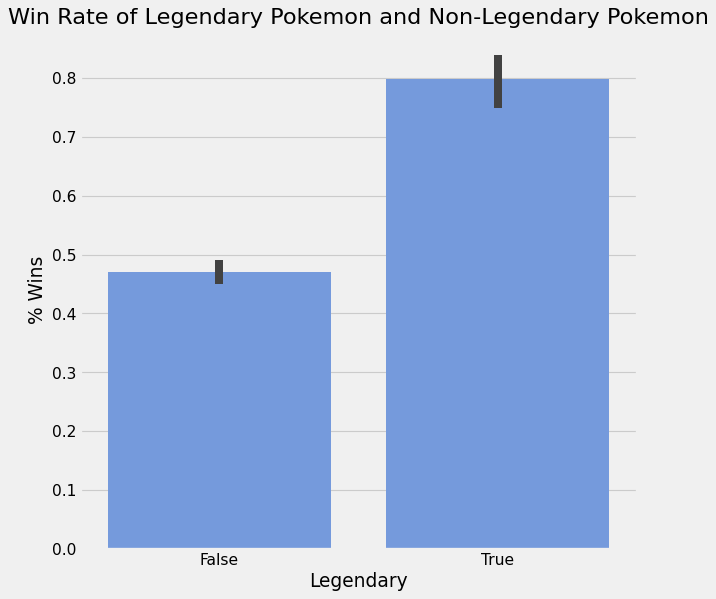

In [ ]:
figure(figsize=(8, 8), dpi=80)
sns.barplot(data = stats_and_wins, y = '% Wins', x ='Legendary', color='cornflowerblue')
plt.title('Win Rate of Legendary Pokemon and Non-Legendary Pokemon');

In [ ]:
def correlation(df, x, y):
    x_su = (df[x] - np.mean(df[x])) / np.std(df[x])
    y_su = (df[y] - np.mean(df[y])) / np.std(df[y])
    return np.mean(x_su * y_su)

Correlation: 0.170827849543183


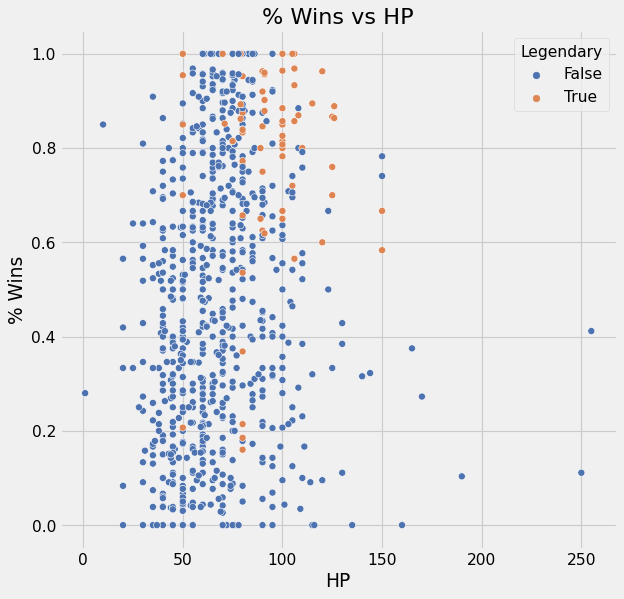

In [ ]:
print('Correlation: ' + str(correlation(stats_and_wins, 'HP', '% Wins')))
figure(figsize=(8, 8), dpi=80)
sns.scatterplot(data = stats_and_wins, x = 'HP', y = '% Wins', s = 40, hue = 'Legendary', palette = 'deep')
plt.title('% Wins vs HP');

Correlation: 0.3758418921112244


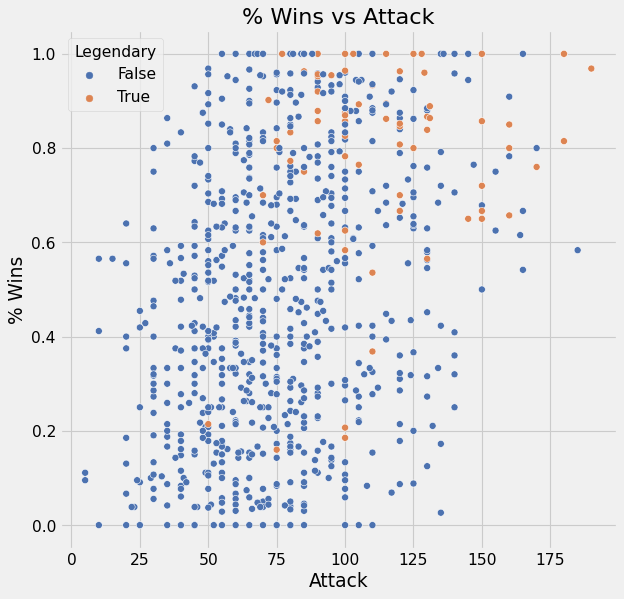

In [ ]:
print('Correlation: ' + str(correlation(stats_and_wins, 'Att', '% Wins')))
figure(figsize=(8, 8), dpi=80)
sns.scatterplot(data = stats_and_wins, x = 'Att', y = '% Wins', s = 40, hue = 'Legendary', palette = 'deep')
plt.title('% Wins vs Attack')
plt.xlabel('Attack');

Correlation: 0.03360566964368149


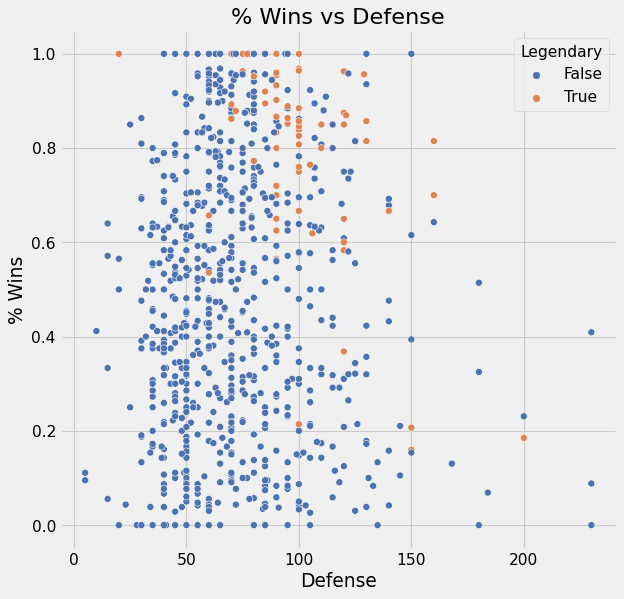

In [ ]:
print('Correlation: ' + str(correlation(stats_and_wins, 'Def', '% Wins')))
figure(figsize=(8, 8), dpi=80)
sns.scatterplot(data = stats_and_wins, x = 'Def', y = '% Wins', s = 40, hue = 'Legendary', palette = 'deep')
plt.title('% Wins vs Defense')
plt.xlabel('Defense');

Correlation: 0.46549297496420367


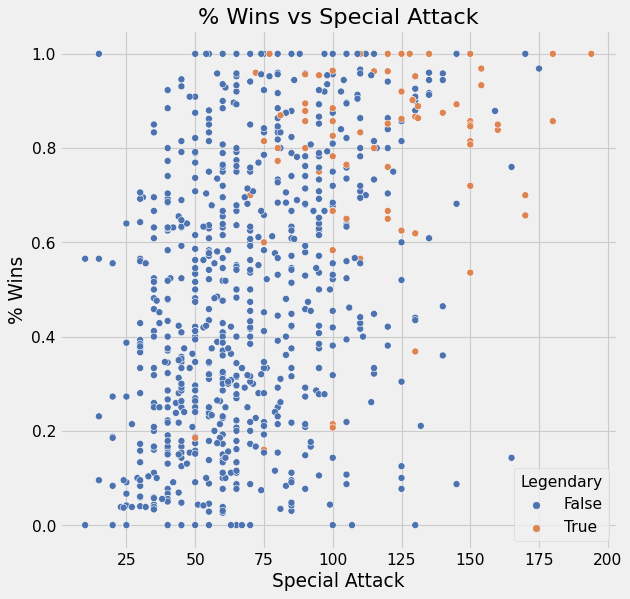

In [ ]:
print('Correlation: ' + str(correlation(stats_and_wins, 'Spa', '% Wins')))
figure(figsize=(8, 8), dpi=80)
sns.scatterplot(data = stats_and_wins, x = 'Spa', y = '% Wins', s = 40, hue = 'Legendary', palette = 'deep')
plt.title('% Wins vs Special Attack')
plt.xlabel('Special Attack');

Correlation: 0.2583590974242524


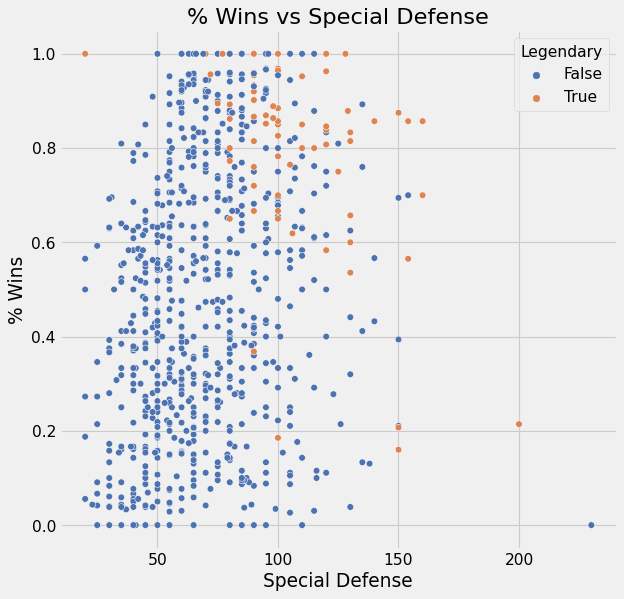

In [ ]:
print('Correlation: ' + str(correlation(stats_and_wins, 'Spd', '% Wins')))
figure(figsize=(8, 8), dpi=80)
sns.scatterplot(data = stats_and_wins, x = 'Spd', y = '% Wins', hue = 'Legendary', palette = 'deep')
plt.title('% Wins vs Special Defense')
plt.xlabel('Special Defense');

Correlation: 0.9429784292355466


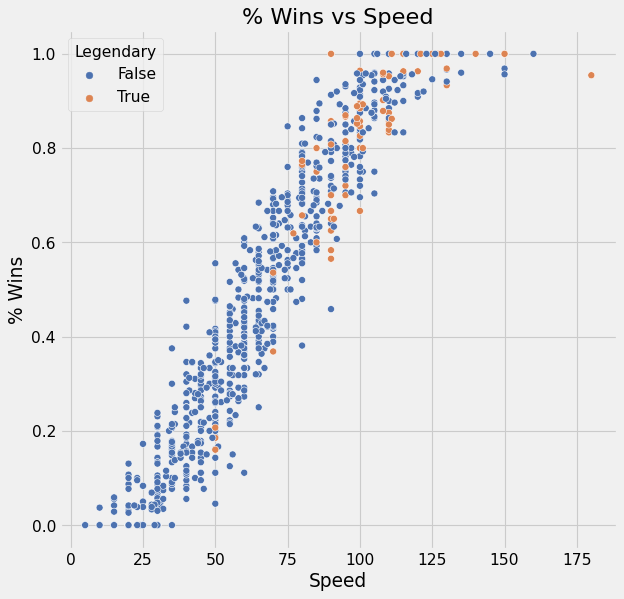

In [ ]:
print('Correlation: ' + str(correlation(stats_and_wins, 'Spe', '% Wins')))
figure(figsize=(8, 8), dpi=80)
sns.scatterplot(data = stats_and_wins, x = 'Spe', y = '% Wins', s = 40, hue = 'Legendary', palette = 'deep')
plt.title('% Wins vs Speed')
plt.xlabel('Speed');

In [ ]:
type_grouped = stats_and_wins.groupby('Type 1').mean().reset_index().rename(columns = {0: 'Type'})
type_grouped.head()

,Type 1,HP,Att,Def,Spa,Spd,Spe,Legendary,Wins,Fights,% Wins
0,Bug,56.884058,71.115942,71.304348,54.159420,65.231884,61.971014,0.014493,10.507246,24.043478,0.431281
1,Dark,66.806452,88.387097,70.225806,74.645161,69.516129,76.161290,0.064516,13.741935,25.161290,0.555241
2,Dragon,85.333333,112.363636,86.787879,97.545455,89.181818,83.242424,0.393939,16.363636,25.121212,0.656621
3,Electric,59.795455,69.090909,66.295455,90.022727,73.704545,84.727273,0.090909,16.840909,25.454545,0.663101
4,Fairy,74.117647,61.529412,65.705882,78.529412,84.705882,48.588235,0.058824,8.647059,25.588235,0.324020


In [ ]:
DeepnoteChart(type_grouped, """{"data":{"name":"placeholder"},"mark":{"type":"bar","tooltip":{"content":"data"}},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"nominal","field":"Type 1","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"% Wins","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [ ]:
second_type = stats_and_wins.drop('Type 1', axis=1).dropna(subset=['Type 2']).rename(columns={'Type 2' : 'Type'})
first_type = stats_and_wins.drop('Type 2', axis=1).rename(columns={'Type 1':'Type'})
repeat_types = first_type.append(second_type)
repeat_types

,Name,Type,HP,Att,Def,Spa,Spd,Spe,Legendary,Pokemon,Wins,Fights,% Wins
0,Bulbasaur,Grass,45,49,49,65,65,45,False,Bulbasaur,3,27,0.111111
1,Ivysaur,Grass,60,62,63,80,80,60,False,Ivysaur,7,24,0.291667
2,Venusaur,Grass,80,82,83,100,100,80,False,Venusaur,21,28,0.750000
3,Mega Venusaur,Grass,80,100,123,122,120,80,False,Mega Venusaur,15,20,0.750000
4,Charmander,Fire,39,52,43,60,50,65,False,Charmander,14,27,0.518519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Fairy,50,100,150,100,150,50,True,Diancie,6,29,0.206897
796,Mega Diancie,Fairy,50,160,110,160,110,110,True,Mega Diancie,17,20,0.850000
797,Hoopa,Ghost,80,110,60,150,130,70,True,Hoopa,15,28,0.535714
798,Hoopa Unbound,Dark,80,160,60,170,130,80,True,Hoopa Unbound,23,35,0.657143


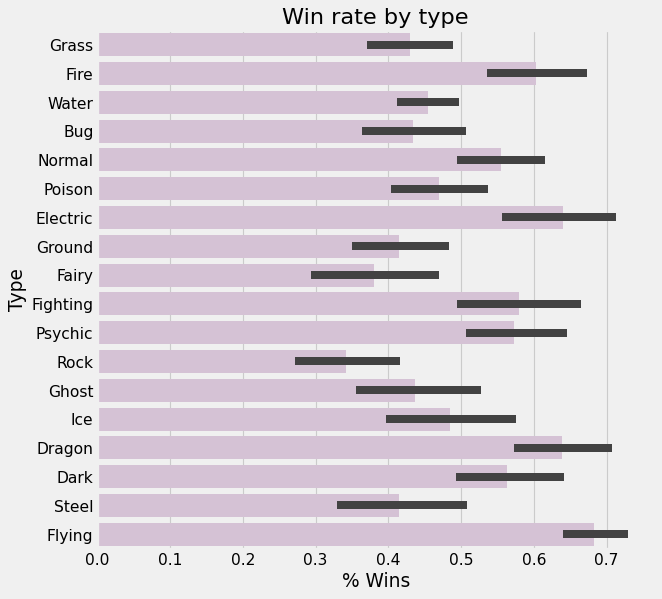

In [ ]:
figure(figsize=(8, 8), dpi=80)
sns.barplot(data = repeat_types, x = '% Wins', y ='Type', orient = 'h', color = 'thistle')
plt.title('Win rate by type');

In [ ]:
tests[0].shape

(9929, 3)

In [ ]:
tests[1].shape

(9929, 8)

In [ ]:
all_tests = tests[0].copy()
for col in tests[1].columns:
    all_tests[col] = tests[1][col]

all_tests.head()

,Pokemon,Opponent,Win,HP diff,Att diff,Def diff,Spa diff,Spd diff,Spe diff,Opponent vs. Pokemon,Pokemon vs. Opponent
0,Seaking,Lickitung,1,-10,37,-10,5,5,38,1.0,1.0
1,Ferrothorn,Quagsire,0,-21,9,46,-11,51,-15,1.0,4.0
2,Thundurus-Therian,Hitmonlee,1,29,-15,17,110,-30,14,0.5,2.0
3,Flaaffy,Maractus,0,-5,-31,-12,-26,-7,-15,1.0,0.5
4,Spearow,Alomomola,1,-125,-15,-50,-9,-14,5,1.0,1.0


In [ ]:
types_and_wins = all_tests.groupby('Pokemon vs. Opponent').mean()
types_and_wins[['Win']]

,Win
Pokemon vs. Opponent,
0.00,0.475138
0.25,0.443299
0.50,0.483500
1.00,0.482118
2.00,0.486718
4.00,0.505051


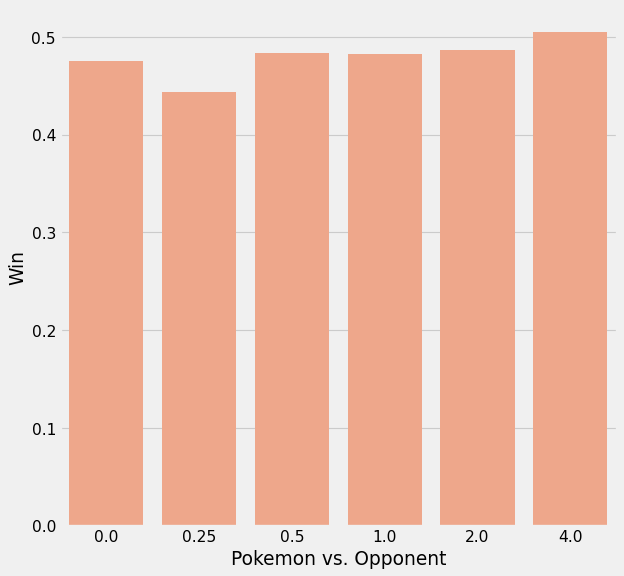

In [ ]:
figure(figsize=(8, 8), dpi=80)
sns.barplot(data = types_and_wins, y = 'Win', x = 'Pokemon vs. Opponent', color = 'lightsalmon')
plt.title('');

In [ ]:
all_tests.groupby('Opponent vs. Pokemon').mean()

,Win,HP diff,Att diff,Def diff,Spa diff,Spd diff,Spe diff,Pokemon vs. Opponent
Opponent vs. Pokemon,,,,,,,,
0.00,0.491124,-2.041420,3.065089,11.088757,5.355030,2.786982,0.786982,1.343195
0.25,0.562963,4.103704,8.770370,16.688889,19.155556,9.970370,9.237037,1.718519
0.50,0.490255,1.700150,6.943028,11.425787,5.973763,5.417541,0.093703,1.504498
1.00,0.481985,-0.982155,-2.316111,-2.511387,-0.651428,-0.590415,-0.401428,1.202158
2.00,0.490942,-0.017210,-1.671649,-1.311594,-0.000453,0.434330,1.256341,1.005661
4.00,0.331658,-0.763819,8.572864,14.592965,-6.793970,-0.788945,-5.567839,0.963568


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b48f097f-607c-418a-bf15-19e0a2612faf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>